In [8]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib notebook

In [2]:
#real[-3.09,2.81], real[-2.39,3.19]
data = np.genfromtxt('banana.dat', dtype=np.float64, delimiter=",")
X,y = data[:,:-1], data[:,-1]
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
c = [1, 10, 1000]
gamma = [0.01, 0.5, 1.0]
cGammaPairs = np.array(np.meshgrid(c, gamma)).T.reshape(-1,2)
folds = [2, 5, 10]

In [3]:
def LinearSVM(x, y, c, k):
    kernel = 'linear'
    linearSVM = [SVC(C=i, kernel=kernel) for i in c]
    eOut = []
    kf = KFold(n_splits=k)
    for lSVM in linearSVM:
        mEOut = []
        for trainIndex, testIndex in kf.split(x):
            xVTrain, yVTrain = x[trainIndex], y[trainIndex]
            xVTest, yVTest = x[testIndex], y[testIndex]
            score = lSVM.fit(xVTrain, yVTrain).score(xVTest, yVTest)
            mEOut.append(1-score)
        eOut.append(np.mean(mEOut))
    return linearSVM, eOut, [1-e for e in eOut]

def PolynomialSVM(x, y, p, k, degree=3, coef0=1):
    kernel = 'poly'
    polySVM = [SVC(C=c, kernel=kernel, gamma=g, coef0=coef0, degree=degree) for c,g in p]
    eOut = []
    kf = KFold(n_splits=k)
    for pSVM in polySVM:
        mEOut = []
        for trainIndex, testIndex in kf.split(x):
            xVTrain, yVTrain = x[trainIndex], y[trainIndex]
            xVTest, yVTest = x[testIndex], y[testIndex]
            score = pSVM.fit(xVTrain, yVTrain).score(xVTest, yVTest)
            mEOut.append(1 - score)
        eOut.append(np.mean(mEOut))
    return polySVM, eOut, [1-e for e in eOut]

def RbfSVM(x, y, p, k):
    kernel = 'rbf'
    rbfSVM = [SVC(C=c, kernel=kernel, gamma=g) for c,g in p]
    eOut = []
    kf = KFold(n_splits=k)
    for rSVM in rbfSVM:
        mEOut = []
        for trainIndex, testIndex in kf.split(x):
            xVTrain, yVTrain = x[trainIndex], y[trainIndex]
            xVTest, yVTest = x[testIndex], y[testIndex]
            score = rSVM.fit(xVTrain, yVTrain).score(xVTest, yVTest)
            mEOut.append(1 - score)
        eOut.append(np.mean(mEOut))
    return rbfSVM, eOut, [1-e for e in eOut]

def SigmoidSVM(x, y, p, k, coef0=1):
    kernel = 'sigmoid'
    sigmoidSVM = [SVC(C=c, kernel=kernel, gamma=g, coef0=coef0) for c,g in p]
    eOut = []
    kf = KFold(n_splits=k)
    for sSVM in sigmoidSVM:
        mEOut = []
        for trainIndex, testIndex in kf.split(x):
            xVTrain, yVTrain = x[trainIndex], y[trainIndex]
            xVTest, yVTest = x[testIndex], y[testIndex]
            score = sSVM.fit(xVTrain, yVTrain).score(xVTest, yVTest)
            mEOut.append(1 - score)
        eOut.append(np.mean(mEOut))
    return sigmoidSVM, eOut, [1-e for e in eOut]

In [ ]:
from sklearn.externals import joblib

linearResults = {2:[], 5:[], 10:[]}
polyResults = {2:[], 5:[], 10:[]}
rbfResults = {2:[], 5:[], 10:[]}
sigmoidResults = {2:[], 5:[], 10:[]}

for k in folds:
    for i, c_ in enumerate(c):
        linearResults[k].append(joblib.load('models/linearKernel_{0}_fold_c_{1}.pkl'.format(k, c_)))
    for i,(c_,g_) in enumerate(cGammaPairs):
        polyResults[k].append(joblib.load('models/polyKernel_{0}_fold_c_{1}_g_{2}.pkl'.format(k, c_, g_)))
        rbfResults[k].append(joblib.load('models/rbfKernel_{0}_fold_c_{1}_g_{2}.pkl'.format(k, c_, g_)))
        sigmoidResults[k].append(joblib.load('models/sigmoidKernel_{0}_fold_c_{1}_g_{2}.pkl'.format(k, c_, g_)))

In [4]:
results = {2:[], 5:[], 10:[]}
foldsBar = tqdm(folds, total=120, ascii=True)
for k in foldsBar:
    foldsBar.set_description("Processing SVM with Linear kernel for %i-fold" % k)
    lModel, lEout, lScore = LinearSVM(xTrain, yTrain, c, k)
    foldsBar.update(10)
    foldsBar.set_description("Processing SVM with Polynomial kernel for %i-fold" % k)
    pModel, pEout, pScore = PolynomialSVM(xTrain, yTrain, cGammaPairs, k)
    foldsBar.update(10)
    foldsBar.set_description("Processing SVM with RBF kernel for %i-fold" % k)
    rModel, rEout, rScore = RbfSVM(xTrain, yTrain, cGammaPairs, k)
    foldsBar.update(10)
    foldsBar.set_description("Processing SVM with Sigmoid kernel for %i-fold" % k)
    sModel, sEout, sScore = SigmoidSVM(xTrain, yTrain, cGammaPairs, k)
    foldsBar.update(10)
    kFoldResults = {'linear':[lModel, lEout, lScore], 'poly':[pModel, pEout, pScore],
                    'rbf':[rModel, rEout, rScore], 'sigmoid':[sModel, sEout, sScore]}
    results[k] = kFoldResults
foldsBar.close()

Processing SVM with Sigmoid kernel for 10-fold:   2%|2         | 3/120 [2:22:59<2:52:25, 88.43s/it]     


In [30]:
results[10]['poly']
r2 = [(int(i* 10**5) / 10.0**5) for i in results[2]['sigmoid'][1]]
r5 = [(int(i* 10**5) / 10.0**5) for i in results[5]['sigmoid'][1]]
r10 = [(int(i* 10**5) / 10.0**5) for i in results[10]['sigmoid'][1]]
print(r2)
print(r5)
print(r10)
print(np.min(r2+r5+r10))

[0.44834, 0.63183, 0.67122, 0.48396, 0.6316, 0.67099, 0.57806, 0.6316, 0.67099]
[0.44834, 0.6599, 0.67806, 0.55448, 0.6566, 0.67806, 0.56957, 0.65754, 0.67806]
[0.44834, 0.66084, 0.67759, 0.56132, 0.65919, 0.67688, 0.56485, 0.65919, 0.67759]
0.44834


In [54]:
print("Eout: ", results[10]['rbf'][0][2].score(xTest, yTest))

Eout:  0.8971698113207547


In [55]:
#Save E_cv results to json
resultsWithoutModel = {2:[], 5:[], 10:[]}
for k in folds:
    rTemp = results[k]
    foldTemp = {'linear':rTemp['linear'][1:], 'poly':rTemp['poly'][1:],
                'rbf':rTemp['rbf'][1:], 'sigmoid':rTemp['sigmoid'][1:]}
    resultsWithoutModel[k] = foldTemp
    
import json
with open('result.json', 'w') as fp:
    json.dump(resultsWithoutModel, fp)

In [6]:
#Dump trained models to file
from sklearn.externals import joblib

for k in folds:
    for i, c_ in enumerate(c):
        joblib.dump(results[k]['linear'][0][i], 'models/linearKernel_{0}_fold_c_{1}.pkl'.format(k, c_))
    for i,(c_,g_) in enumerate(cGammaPairs):
        joblib.dump(results[k]['poly'][0][i], 'models/polyKernel_{0}_fold_c_{1}_g_{2}.pkl'.format(k, c_, g_))
        joblib.dump(results[k]['rbf'][0][i], 'models/rbfKernel_{0}_fold_c_{1}_g_{2}.pkl'.format(k, c_, g_))
        joblib.dump(results[k]['sigmoid'][0][i], 'models/sigmoidKernel_{0}_fold_c_{1}_g_{2}.pkl'.format(k, c_, g_))

### Plot SVM with Linear Kernel boundaries and support vectors

[1014  963]


<IPython.core.display.Javascript object>


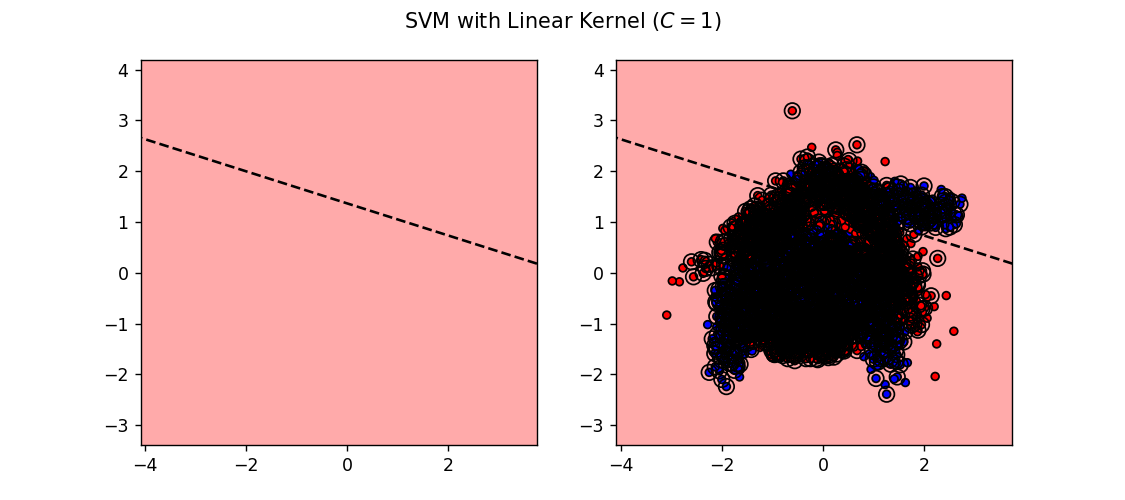

In [45]:
clf = results[2]['linear'][0][1]
support_vectors = clf.support_vectors_
print(clf.n_support_)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min = xTrain[:, 0].min()-1
x_max = xTrain[:, 0].max()+1
y_min = xTrain[:, 1].min()-1
y_max = xTrain[:, 1].max()+1

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

Z = Z.reshape(XX.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

ax1.pcolormesh(XX, YY, Z > 0, cmap=cmap_light)
ax2.pcolormesh(XX, YY, Z > 0, cmap=cmap_light)
ax1.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-1, 0, 1])
ax2.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-1, 0, 1])

ax2.scatter(xTrain[:, 0], xTrain[:, 1], c=yTrain, zorder=10, cmap=cmap_bold,
            edgecolor='k', s=20)


# Circle out the support vectors
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=80, facecolors='none',
            zorder=10, edgecolor='k')

f.suptitle(r'SVM with Linear Kernel $(C = 1)$')
plt.show()

### Plot SVM with Polynomial Kernel boundaries and support vectors

[1129 1128]


<IPython.core.display.Javascript object>


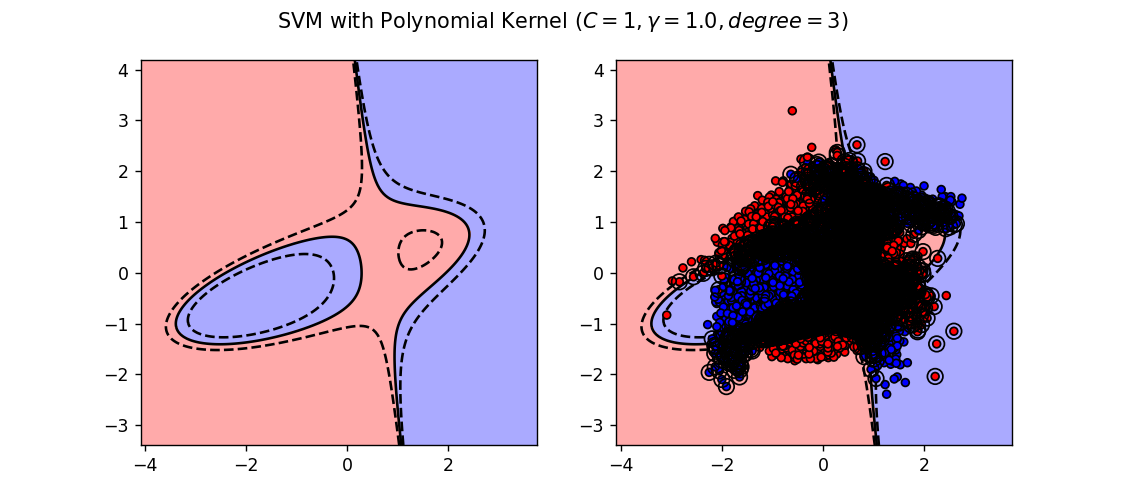

In [46]:
clf = results[10]['poly'][0][2]
support_vectors = clf.support_vectors_
print(clf.n_support_)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min = xTrain[:, 0].min()-1
x_max = xTrain[:, 0].max()+1
y_min = xTrain[:, 1].min()-1
y_max = xTrain[:, 1].max()+1

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

Z = Z.reshape(XX.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

ax1.pcolormesh(XX, YY, Z > 0, cmap=cmap_light)
ax2.pcolormesh(XX, YY, Z > 0, cmap=cmap_light)
ax1.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-1, 0, 1])
ax2.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-1, 0, 1])

ax2.scatter(xTrain[:, 0], xTrain[:, 1], c=yTrain, zorder=10, cmap=cmap_bold,
            edgecolor='k', s=20)


# Circle out the support vectors
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=80, facecolors='none',
            zorder=10, edgecolor='k')

f.suptitle(r'SVM with Polynomial Kernel $(C = 1, \gamma = 1.0, degree = 3)$')
plt.show()

### Plot SVM with RBF Kernel boundaries and support vectors

[489 493]
rho:  0.032289104150273244


<IPython.core.display.Javascript object>


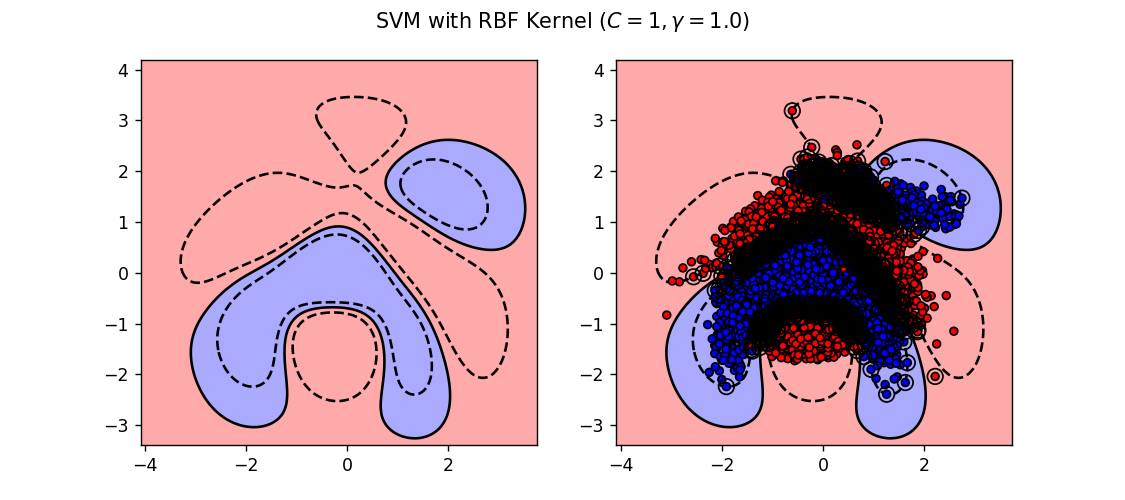

In [52]:
clf = results[10]['rbf'][0][2]
# support_vectors = clf.support_vectors_
print(clf.n_support_)
print("rho: ", 1/np.linalg.norm(clf.dual_coef_))
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min = xTrain[:, 0].min()-1
x_max = xTrain[:, 0].max()+1
y_min = xTrain[:, 1].min()-1
y_max = xTrain[:, 1].max()+1

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

Z = Z.reshape(XX.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

ax1.pcolormesh(XX, YY, Z > 0, cmap=cmap_light)
ax2.pcolormesh(XX, YY, Z > 0, cmap=cmap_light)
ax1.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-1, 0, 1])
ax2.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-1, 0, 1])

ax2.scatter(xTrain[:, 0], xTrain[:, 1], c=yTrain, zorder=10, cmap=cmap_bold,
            edgecolor='k', s=20)


# Circle out the support vectors
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=80, facecolors='none',
            zorder=10, edgecolor='k')

f.suptitle(r'SVM with RBF Kernel $(C = 1, \gamma = 1.0)$')
plt.show()

### Plot SVM with Sigmoid Kernel boundaries and support vectors

[1712 1709]


<IPython.core.display.Javascript object>


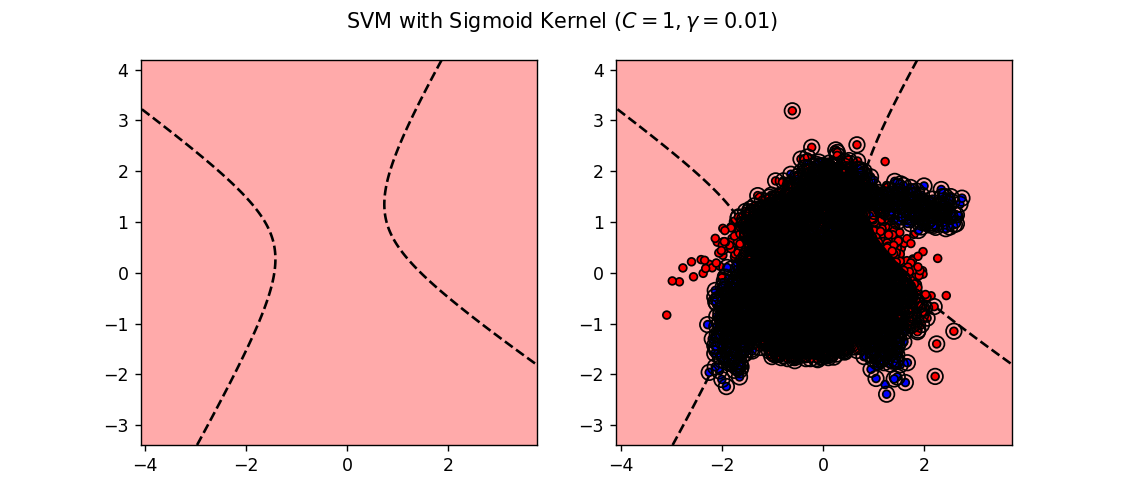

In [48]:
clf = results[10]['sigmoid'][0][0]
support_vectors = clf.support_vectors_
print(clf.n_support_)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min = xTrain[:, 0].min()-1
x_max = xTrain[:, 0].max()+1
y_min = xTrain[:, 1].min()-1
y_max = xTrain[:, 1].max()+1

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

Z = Z.reshape(XX.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

ax1.pcolormesh(XX, YY, Z > 0, cmap=cmap_light)
ax2.pcolormesh(XX, YY, Z > 0, cmap=cmap_light)
ax1.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-1, 0, 1])
ax2.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-1, 0, 1])

ax2.scatter(xTrain[:, 0], xTrain[:, 1], c=yTrain, zorder=10, cmap=cmap_bold,
            edgecolor='k', s=20)


# Circle out the support vectors
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=80, facecolors='none',
            zorder=10, edgecolor='k')

f.suptitle(r'SVM with Sigmoid Kernel $(C = 1, \gamma = 0.01)$')
plt.show()